In [1]:
#!pip install kramersmoyal
import pandas as pd
import numpy as np
from kramersmoyal import km

import os
   
from utils.Data_cleaning import data_cleaning
from utils.Functions import data_filter, integrate_omega, KM_Coeff_1, KM_Coeff_2, daily_profile, power_mismatch, exp_decay, Euler_Maruyama, Increments, autocor 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.optimizers import SR3
from scipy.ndimage import gaussian_filter1d
#import sdeint

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

#### Choose the grid: (Balearic, Irish or Iceland)

In [3]:
#grids = ['IS02','IRL01','ES_PM01']  
#grids = ['Balearic','Irish','Iceland' ]  
#grids = ['Iceland']  
#grids = ['Irish']
grids = ['Balearic']

In [4]:
dict_grids = {'Balearic':'ES_PM01','Irish':'IRL01','Iceland':'IS02'}
#dict_freq_grids = {'Balearic':'f50_ES_PM','Irish':'f50_IRL01'}
dict_freq_grids = {'Balearic':'f50_ES_PM','Irish':'f50_IRL01','Iceland':'f50_IS' }

In [5]:
models = ['model 1','model 2','model 3','model 4']

#freq_orig = data/(2*np.pi+50)
#increments_orig = Increments(data/(2*np.pi+50))

'''For calculations: use angular velocity omega = 2*pi*frequency '''
'''The bandwidth is chosen such that we receive a scmooth distribution'''

'''Choose the grid '''

'''Data analysis of the original time series'''
data_orig          = {i:[]for i in grids}



edges_1d     = {i:[]for i in grids}
drift_1d     = {i:[]for i in grids}
diffusion_1d = {i:[]for i in grids}
edges_2d     = {i:[]for i in grids}
kmc_2d       = {i:[]for i in grids}

for grid in grids:
    time_res = 1
    '''Choose the grid '''
    #raw=pd.read_csv('./Data/Frequency_data_%s.csv'%(grid), sep=',')  
    #freq = (raw[['Frequency']]/1000 +50).squeeze()
    #freq = data_cleaning(freq)
    
    raw=pd.read_csv('Data/%s.csv'%(dict_grids[grid]), sep=';')  
    freq = (raw[[dict_freq_grids[grid]]]/1000 +50).squeeze()
    freq = data_cleaning(freq)
    
    #print(freq)


    data_orig[grid].append(freq)
   

Number of too high frequency values:  0 Number of too low frequency values:  0
Number of too large increments:  88
Number of windows with constant frequency for longer than 60s:  0
Number of Nan-intervals:  0
Clean corrupted data ...


The empirical data is given by data_orig[grid] (grid = Irish, Iceland, Balearic.)
In the following the different models are calculated, i.e. the synthetic time series is given by "omega_synth_model_i" (i=1,2,3,4).
\
The default length of the calculated synthetic time series is 5 days (t_final=5).
\
The time step delta_t should be chosen smaller or equal than one. Here we use delta_t = 0.1.

In [6]:
def extract_data (data_set, n=900):
    """
    Extract  'omega' and 'theta' from the given dataset.
    """
    # Check if the dataset is not empty
    if data_set:
        omega = data_set[0][0]
        theta = data_set[0][1]

        
        omega_extract = omega[:n]
        theta_extract = theta[:n]

        return omega_extract, theta_extract

In [7]:
import numpy as np
import pywt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

def apply_filters_and_plot(omega, sigma=10, wavelet='db4', level=10):
    """
    Apply Gaussian and Wavelet filters to the data and plot the results.

    Parameters:
    omega (array): The input data.
    sigma (int): Standard deviation for the Gaussian kernel.
    wavelet (str): The type of wavelet to use.
    level (int): The level of wavelet decomposition.
    """

    # Apply Gaussian Filter for Diffusion
    gaussian_filtered_data = gaussian_filter1d(omega, sigma)

    # Apply Wavelet Filter for External Force
    coeffs = pywt.wavedec(gaussian_filtered_data, wavelet, level=level)
    coeffs[1:] = [np.zeros_like(coeff) for coeff in coeffs[1:]]  # Zero out coefficients
    wavelet_filtered_data = pywt.waverec(coeffs, wavelet)

    # Plot the results with both filters applied
    plt.figure(figsize=(12, 6))
    plt.plot(omega, label='Original Data', alpha=0.5)
    plt.plot(gaussian_filtered_data, label='Gaussian Filtered Data', color='red')
    plt.plot(wavelet_filtered_data, label='Wavelet Filtered Data', color='blue', alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Drift Extraction with Gaussian and Wavelet Filters')
    plt.legend()
    plt.show()

    return gaussian_filtered_data, wavelet_filtered_data

In [8]:
def gaussian_filter(omega, sigma=10):
    """
    Apply a Gaussian filter to the data and plot the results.

    Parameters:
    omega (array): The input data.
    sigma (int): Standard deviation for the Gaussian kernel.
    """

    # Apply Gaussian Filter for Smoothing
    gaussian_filtered_data = gaussian_filter1d(omega, sigma)

    # Plot the results with Gaussian filter applied
    plt.figure(figsize=(8, 3))
    plt.plot(omega, label='Original Data', alpha=0.5)
    plt.plot(gaussian_filtered_data, label='Gaussian Filtered Data', color='red')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Data Smoothing with Gaussian Filter')
    plt.legend()
    plt.show()

    return gaussian_filtered_data



In [9]:
from scipy.signal import savgol_filter

def savitzky_golay_filter(omega, window_size=15, poly_order=2):
    """
    Apply a Savitzky-Golay filter to the data and plot the results.

    Parameters:
    omega (array): The input data.
    window_size (int): Size of the smoothing window.
    poly_order (int): Order of the polynomial to fit.
    """

    # Apply Savitzky-Golay Filter for Smoothing
    savitzky_golay_filtered_data = savgol_filter(omega, window_size, poly_order)

    # Plot the results with Savitzky-Golay filter applied
    plt.figure(figsize=(12, 6))
    plt.plot(omega, label='Original Data', alpha=0.5)
    plt.plot(savitzky_golay_filtered_data, label=f'Savitzky-Golay Filter (Window Size={window_size}, Order={poly_order})', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Data Smoothing with Savitzky-Golay Filter')
    plt.legend()
    plt.show()

    return savitzky_golay_filtered_data


In [10]:
def integrate_data(data, dt=1):
    """
    Manually integrate the data using a simple Euler integration method.

    Parameters:
    data (array): The input data to be integrated.
    dt (float): The time step for integration.

    Returns:
    integrated_data: The integrated data.
    """
    
    integrated_data = np.zeros(len(data))
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt
    return integrated_data

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def compare_simulated_to_original(model, theta, data, initial_condition):
    """
    Simulate a system using the SINDy model and compare the simulated results to the original data.

    Parameters:
    model: The trained SINDy model.
    theta (array): The original theta data.
    omega (array): The original omega data.
    initial_condition (list): The initial conditions for the simulation.

    Plot:
    Comparison plots for theta and omega.
    """
    
    total_time = len(theta)
    time_points = np.arange(0, total_time, 1)

    # Simulate the system
    simulated_data = model.simulate(initial_condition, time_points)

    # Extract simulated theta and omega
    simulated_theta = simulated_data[:, 0]
    simulated_omega = simulated_data[:, 1]

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot theta and simulated theta
    plt.subplot(2, 1, 1)
    plt.plot(theta, label='Original Theta')
    plt.plot(simulated_theta, label='Simulated Theta', linestyle='--')
    plt.title('Comparison of Original Theta and Simulated Theta')
    plt.legend()

    # Plot omega and simulated omega
    plt.subplot(2, 1, 2)
    plt.plot(data, label='Original Omega')
    plt.plot(simulated_omega, label='Simulated Omega', linestyle='--')
    plt.title('Comparison of Original Omega and Simulated Omega')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Model 2 

In [12]:
'''Model 2...'''
'''Model 2...'''
np.random.seed(12345678)
noise_data_model_2 = {i:[]for i in grids}
ideal_data_model_2 = {i:[]for i in grids}
time_data_model_2 = {i:[]for i in grids}
c_1_model2 = {i:[]for i in grids}
c_2_model2 = {i:[]for i in grids}
epsilon_model2 = {i:[]for i in grids}

'''adapt the parameter estimation to the particulat grids'''
for grid in grids:

    #raw=pd.read_csv('./Data/Frequency_data_%s.csv'%(grid), sep=',')
    #freq = (raw[['Frequency']]/1000 +50).squeeze()
    #freq = data_cleaning(freq)
    
    raw=pd.read_csv('Data/%s.csv'%(dict_grids[grid]), sep=';')  
    freq = (raw[[dict_freq_grids[grid]]]/1000 +50).squeeze()
    freq = data_cleaning(freq)
    
    data = (freq-50)*(2*np.pi)   #Use the angular velocity for the calcualltions

    trend = 1 #trend is boolean
    bw_drift = 0.1
    bw_diff = 0.1
    dist_drift = 500    #for large data set: dist_drift = 350 for Balearic
    dist_diff = 500
    if grid == 'Balearic':
        Delta_P = power_mismatch(data,avg_for_each_hour = False,dispatch=2,start_minute=0,end_minute=1/6,length_seconds_of_interval=5)
        dispatch = 1
    elif grid == 'Irish':
        Delta_P = power_mismatch(data_filter(data,sigma = 6),avg_for_each_hour = False,dispatch=1,start_minute=0,end_minute=1/6,length_seconds_of_interval=5)
        dispatch = 2
        #we use a filter for the power mismatch of the Iroish data because of regular outliers (every 60 seconds)
    elif grid == 'Iceland':
        Delta_P = 0
        dispatch = 0
        trend = 0 # Represents a no-existing trend as there is no power dispatch schedule
        
    c_1 = KM_Coeff_1(data - trend*data_filter(data),dim= 1,time_res = 1,bandwidth = bw_drift,dist = dist_drift, order = 1)
    c_2_decay = trend*exp_decay(data,time_res=1,size = 899)
    epsilon =   epsilon = KM_Coeff_2(data - trend*data_filter(data),dim = 1,time_res = 1,bandwidth = bw_diff,dist = dist_diff,multiplicative_noise = False)
    #epsilon = 0

    kmc,edges = km(data - trend * data_filter(data),powers = [0,1,2],bins = np.array([6000]),bw=bw_drift)
    edges_1d[grid] = edges[0]
    drift_1d[grid] = kmc[1]
    diffusion_1d[grid] = kmc[2] 
    c_1_model2[grid] = c_1
    c_2_model2[grid] = c_2_decay * c_1
    epsilon_model2[grid] = epsilon

    delta_t = 1 #time step for Euler-Maruyama
    
    # with noise there are 96 intervals of 15 minutes each in one day.
    omega_noise_model_2, theta_noise_model_2, p1 = Euler_Maruyama(data,c_1=c_1,c_2_decay=c_2_decay,Delta_P = Delta_P,
                                                              epsilon=epsilon,time_res = 1,dispatch = dispatch,
                                                              delta_t=delta_t,t_final=900*4,model=2,factor_daily_profile=0,sawtooth = False)
    # without noise, set epsilon = 0
    omega_ideal_model_2, theta_ideal_model_2, p2= Euler_Maruyama(data,c_1=c_1,c_2_decay=c_2_decay,Delta_P = Delta_P,
                                                              epsilon=0,time_res = 1,dispatch = dispatch,
                                                              delta_t=delta_t,t_final=900*4,model=2,factor_daily_profile=0,sawtooth = False)
    # with sawtooth = True
    omega_time_model_2, theta_time_model_2, p3= Euler_Maruyama(data,c_1=c_1,c_2_decay=c_2_decay,Delta_P = Delta_P,
                                                              epsilon=epsilon,time_res = 1,dispatch = dispatch,
                                                              delta_t=delta_t,t_final=900*4,model=2,factor_daily_profile=0,sawtooth = True)
    
    #freq_synth_model_2 = omega_synth_model_2/(2*np.pi) + 50

    noise_data_model_2[grid].append((omega_noise_model_2, theta_noise_model_2))
    ideal_data_model_2[grid].append((omega_ideal_model_2, theta_ideal_model_2))
    time_data_model_2[grid].append((omega_time_model_2, theta_time_model_2))


Number of too high frequency values:  0 Number of too low frequency values:  0
Number of too large increments:  88
Number of windows with constant frequency for longer than 60s:  0
Number of Nan-intervals:  0
Clean corrupted data ...


In [13]:
Bal_noise = noise_data_model_2['Balearic']
Bal_ideal = ideal_data_model_2['Balearic']
Bal_time = time_data_model_2['Balearic']

In [14]:
omega_Bal_noise, theta_Bal_noise = extract_data(Bal_noise,n=900*4)
omega_Bal_ideal, theta_Bal_ideal = extract_data(Bal_ideal,n=900*4)
omega_Bal_time, theta_Bal_time = extract_data(Bal_time,n=900*4)

In [15]:
np.mean(p3)

-1.010352802231456e-06

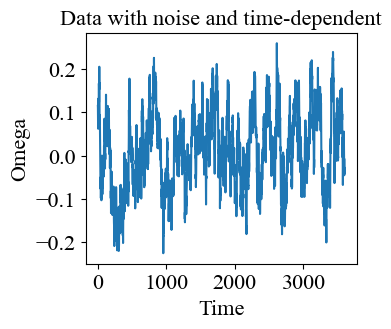

In [42]:
# Set the figure size
plt.figure(figsize=(3.5, 3))  # Adjust the width and height as needed

# Plot the data
plt.plot(omega_Bal_time)

# Set x and y labels
plt.title('Data with noise and time-dependent', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Omega', fontsize=16)

# Set x and y ticks font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Show the plot
plt.show()

In [16]:
def sindy_model(filtered_data, dt=1, threshold=1e-10, n=2, ensemble=False, library_ensemble=False):
    # Integrate omega to get theta
    theta = integrate_data(filtered_data, dt)
    
    # Stack normalized theta and data
    x_train = np.column_stack((theta, filtered_data))
    
    # Generate time values
    t_train = np.arange(0, len(filtered_data), 1)
    
    # Add time as a linear feature
    linear_time_feature = t_train.reshape(-1, 1)
    x_train_augmented = np.hstack([x_train, linear_time_feature])

    # Feature names for SINDy (including a linear term for time)
    feature_names = ["theta", "omega", "linear_time"]

    # Use Polynomial Library 
    polynomial_library = ps.PolynomialLibrary(degree=n)

    # Sparse regression optimizer
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold)

    # Create a SINDy model with the polynomial library
    model = ps.SINDy(feature_names=feature_names, 
                     feature_library=polynomial_library,
                     optimizer=sparse_regression_optimizer)
    
    # Fit the model based on the specified parameters
    if ensemble:
        model.fit(x_train_augmented, t=dt, ensemble=True, quiet=True)
    elif library_ensemble:
        model.fit(x_train_augmented, t=dt, library_ensemble=True, quiet=True)
    else:
        model.fit(x_train_augmented, t=dt)

    # Print the model coefficients
    model.print(precision=7)
    
    # Print the model score
    print("Model Score:", model.score(x_train_augmented, t=dt))
    
    return model
    

In [17]:
c_1_model2

{'Balearic': array([-0.0295151])}

In [18]:
c_2_model2

{'Balearic': array([-4.51579245e-05])}

In [19]:
model2=sindy_model(omega_Bal_ideal, threshold=1e-10,n=2)

(theta)' = 0.0013870 1 + 0.0002567 theta + 0.9946700 omega + -0.0000312 linear_time + -0.0000034 theta^2 + -0.0021781 theta omega + 0.0000004 theta linear_time + -0.0467587 omega^2 + 0.0002393 omega linear_time
(omega)' = 0.0036988 1 + -0.0000532 theta + -0.0301337 omega + 0.0000008 linear_time + 0.0000001 theta^2 + 0.0000571 theta omega + 0.0011936 omega^2 + -0.0000063 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666666638973068


(theta)' = 0.0013870 1 + 0.0002567 theta + 0.9946700 omega + -0.0000312 linear_time + -0.0000034 theta^2 + -0.0021781 theta omega + 0.0000004 theta linear_time + -0.0467587 omega^2 + 0.0002393 omega linear_time
(omega)' = 0.0036988 1 + -0.0000532 theta + -0.0301337 omega + 0.0000008 linear_time + 0.0000001 theta^2 + 0.0000571 theta omega + 0.0011936 omega^2 + -0.0000063 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.6666666638973068


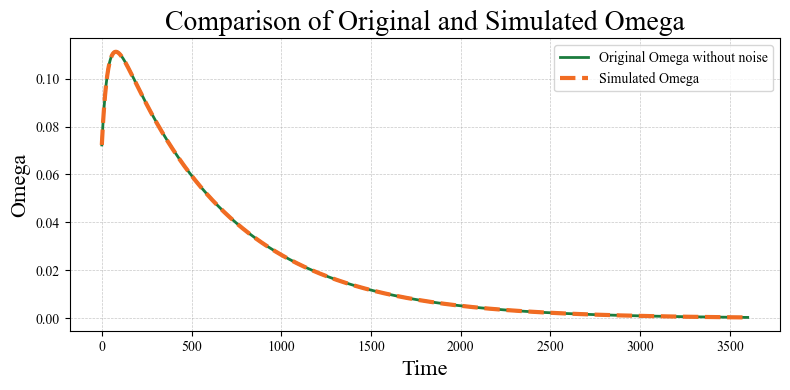

In [20]:
data=omega_Bal_ideal
theta = theta_Bal_ideal
dt=1
model2=sindy_model(data,threshold=1e-10,n=2)

# Simulate the system
total_time = len(theta)
time_points = np.arange(0, total_time, 1)

initial_condition = [theta[0], data[0], 0.00]
simulated_data = model2.simulate(initial_condition, time_points)

# Extract simulated theta and omega
simulated_theta = simulated_data[:, 0]
simulated_omega = simulated_data[:, 1]

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(8, 4))

# Plot with specific colors for each line
#plt.plot(omega_Bal_noise, label='Original Omega with noise', alpha=0.7, color='#2b6a99')
plt.plot(data, label='Original Omega without noise', linestyle='-', linewidth=2,  color='#1b7c3d')
plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3,  color='#f16c23')

# Plot Gaussian Filtered Omega with sigma=20 for comparison
#plt.plot(data_sigma_20, label='Gaussian Filtered Omega (sigma=20)', linestyle='-', linewidth=2, alpha=0.6,color='#1b7c3d')
# Plot Simulated Omega with sigma=20
#plt.plot(simulated_omega_sigma_20, label='Simulated Omega (sigma=20)', linestyle='--', linewidth=3, alpha=0.6,color='#f16c23')


plt.title('Comparison of Original and Simulated Omega', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Omega', fontsize=16)
plt.legend(loc='upper right')  
plt.locator_params(axis='x', nbins=10)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [75]:
c_1_model2['Balearic']

array([-0.0295151])

In [37]:
model2.get_feature_names()

['1',
 'theta',
 'omega',
 'linear_time',
 'theta^2',
 'theta omega',
 'theta linear_time',
 'omega^2',
 'omega linear_time',
 'linear_time^2']

In [21]:
data=gaussian_filter1d(omega_Bal_noise, sigma=90)
theta = integrate_data(data, dt=1)
dt=1
model2=sindy_model(data,threshold=1e-10,n=2)

# Simulate the system
total_time = len(theta)
time_points = np.arange(0, total_time, 1)

initial_condition = [theta[0], data[0], 0.00]
simulated_data = model2.simulate(initial_condition, time_points)

# Extract simulated theta and omega
simulated_theta = simulated_data[:, 0]
simulated_omega = simulated_data[:, 1]


(theta)' = -0.0001013 1 + -0.0000040 theta + 0.9976295 omega + 0.0000009 linear_time + 0.0000016 theta omega + 0.0149860 omega^2 + 0.0000009 omega linear_time
(omega)' = -0.0002150 1 + -0.0000078 theta + -0.0046469 omega + 0.0000019 linear_time + -0.0000001 theta^2 + 0.0000019 theta omega + 0.0299752 omega^2 + 0.0000019 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.5310814520465877


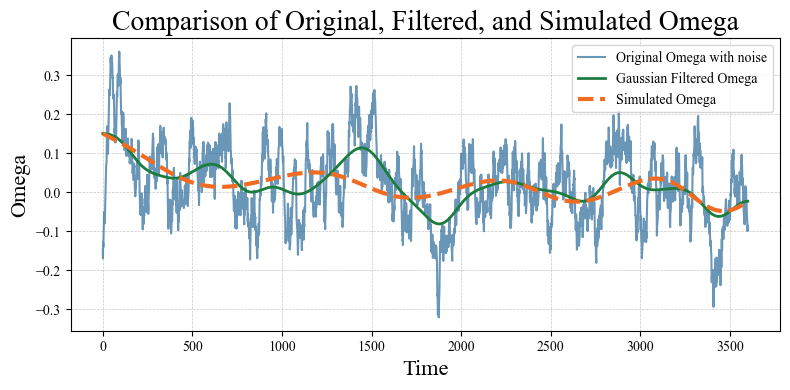

In [22]:
#plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(8, 4))

# Plot with specific colors for each line
plt.plot(omega_Bal_noise, label='Original Omega with noise', alpha=0.7, color='#2b6a99')
plt.plot(data, label='Gaussian Filtered Omega', linestyle='-', linewidth=2,  color='#1b7c3d')
plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3,  color='#f16c23')

plt.title('Comparison of Original, Filtered, and Simulated Omega', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Omega', fontsize=16)
plt.legend(loc='upper right')  
plt.locator_params(axis='x', nbins=10)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

(theta)' = 0.0040819 1 + -0.0002235 theta + 0.9912947 omega + 0.0000065 linear_time + 0.0000018 theta^2 + 0.0001401 theta omega + -0.0000001 theta linear_time + 0.0001262 omega^2 + -0.0000011 omega linear_time
(omega)' = 0.0078958 1 + -0.0004412 theta + -0.0157401 omega + 0.0000130 linear_time + 0.0000035 theta^2 + 0.0002739 theta omega + -0.0000001 theta linear_time + 0.0010907 omega^2 + -0.0000022 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.36188242155833233
(theta)' = 0.0035045 1 + -0.0001940 theta + 0.9921136 omega + 0.0000057 linear_time + 0.0000015 theta^2 + 0.0001307 theta omega + -0.0000001 theta linear_time + 0.0008171 omega^2 + -0.0000010 omega linear_time
(omega)' = 0.0068411 1 + -0.0003838 theta + -0.0146688 omega + 0.0000114 linear_time + 0.0000030 theta^2 + 0.0002526 theta omega + -0.0000001 theta linear_time + 0.0019119 omega^2 + -0.0000020 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.38537712828693677
(theta)' = 0.0024587 1 + -0.000140

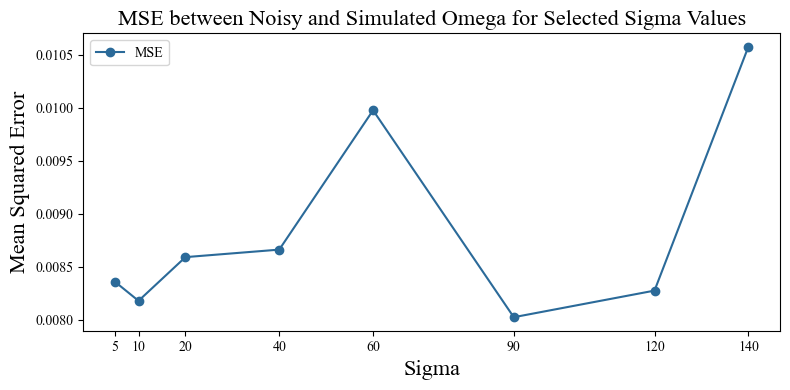

In [21]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_squared_error
plt.rcParams['font.family'] = 'Times New Roman'
# Specific sigma values to test
sigma_values = np.array([5, 10, 20, 40, 60, 90, 120, 140])
mse_values = []

for sigma in sigma_values:
    # Apply Gaussian filter with current sigma
    data_filtered = gaussian_filter1d(omega_Bal_noise, sigma=sigma)
    
    # Integrate the filtered data to get theta (assuming integrate_data function is defined)
    theta = integrate_data(data_filtered, dt=1)
    
    # Run the SINDy model (assuming sindy_model function and necessary libraries are imported)
    model2 = sindy_model(data_filtered, threshold=1e-10, n=2)
    initial_condition = [theta[0], data_filtered[0], 0.00]
    simulated_data = model2.simulate(initial_condition, time_points)
    
    # Extract simulated omega
    simulated_omega = simulated_data[:, 1]
    
    # Calculate the MSE and store it
    mse = mean_squared_error(omega_Bal_noise, simulated_omega)
    mse_values.append(mse)

# Plot the MSE against sigma values
plt.figure(figsize=(8, 4))
plt.plot(sigma_values, mse_values, label='MSE', marker='o', linestyle='-', color='#2b6a99')

plt.title('MSE between Noisy and Simulated Omega for Selected Sigma Values', fontsize=16)
plt.xlabel('Sigma', fontsize=16)
plt.ylabel('Mean Squared Error', fontsize=16)
plt.xticks(sigma_values)  # Set x-ticks to be the sigma values
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()



(theta)' = 0.0003850 1 + -0.0000316 theta + 0.9968328 omega + 0.0000017 linear_time + 0.0000002 theta^2 + 0.0000257 theta omega + 0.0084783 omega^2 + 0.0000005 omega linear_time
(omega)' = 0.0007367 1 + -0.0000622 theta + -0.0060950 omega + 0.0000034 linear_time + 0.0000004 theta^2 + 0.0000479 theta omega + 0.0168107 omega^2 + 0.0000010 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.47142923767834377


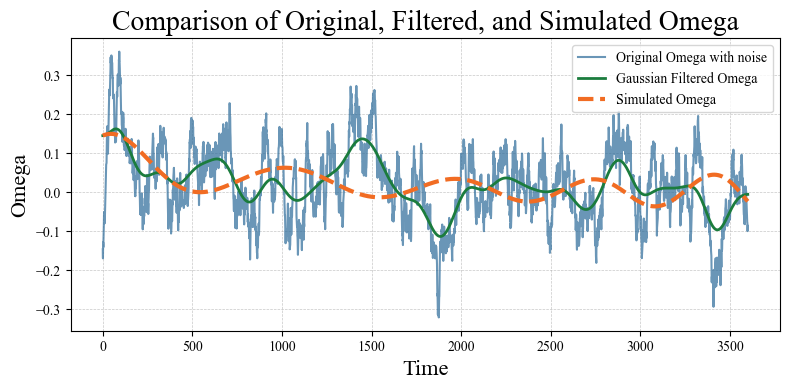

In [23]:
data=gaussian_filter1d(omega_Bal_noise, sigma=60)
theta = integrate_data(data, dt=1)
dt=1
model2=sindy_model(data,threshold=1e-10,n=2)

# Simulate the system
total_time = len(theta)
time_points = np.arange(0, total_time, 1)

initial_condition = [theta[0], data[0], 0.00]
simulated_data = model2.simulate(initial_condition, time_points)

# Extract simulated theta and omega
simulated_theta = simulated_data[:, 0]
simulated_omega = simulated_data[:, 1]

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(8, 4))

# Plot with specific colors for each line
plt.plot(omega_Bal_noise, label='Original Omega with noise', alpha=0.7, color='#2b6a99')
plt.plot(data, label='Gaussian Filtered Omega', linestyle='-', linewidth=2,  color='#1b7c3d')
plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3,  color='#f16c23')

# Plot Gaussian Filtered Omega with sigma=20 for comparison
#plt.plot(data_sigma_20, label='Gaussian Filtered Omega (sigma=20)', linestyle='-', linewidth=2, alpha=0.6,color='#1b7c3d')
# Plot Simulated Omega with sigma=20
#plt.plot(simulated_omega_sigma_20, label='Simulated Omega (sigma=20)', linestyle='--', linewidth=3, alpha=0.6,color='#f16c23')


plt.title('Comparison of Original, Filtered, and Simulated Omega', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Omega', fontsize=16)
plt.legend(loc='upper right')  
plt.locator_params(axis='x', nbins=10)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

(theta)' = -0.0000782 1 + -0.0000686 theta + 0.9995693 omega + -0.0000031 linear_time + -0.0000005 theta^2 + 0.0000016 theta omega + 0.0111953 omega^2 + -0.0000004 omega linear_time
(omega)' = -0.0001497 1 + -0.0001403 theta + 0.0000304 omega + -0.0000063 linear_time + -0.0000010 theta^2 + -0.0000260 theta omega + -0.0000001 theta linear_time + 0.0262217 omega^2 + -0.0000005 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.36002013172045705
(theta)' = -0.0001450 1 + -0.0000663 theta + 1.0000441 omega + -0.0000026 linear_time + -0.0000005 theta^2 + 0.0000027 theta omega + 0.0133969 omega^2 + -0.0000005 omega linear_time
(omega)' = -0.0002955 1 + -0.0001334 theta + 0.0006290 omega + -0.0000053 linear_time + -0.0000010 theta^2 + 0.0000003 theta omega + 0.0299023 omega^2 + -0.0000009 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.3834641468411178
(theta)' = -0.0001927 1 + -0.0000569 theta + 1.0010928 omega + -0.0000020 linear_time + -0.0000005 theta^2 + 0.000036

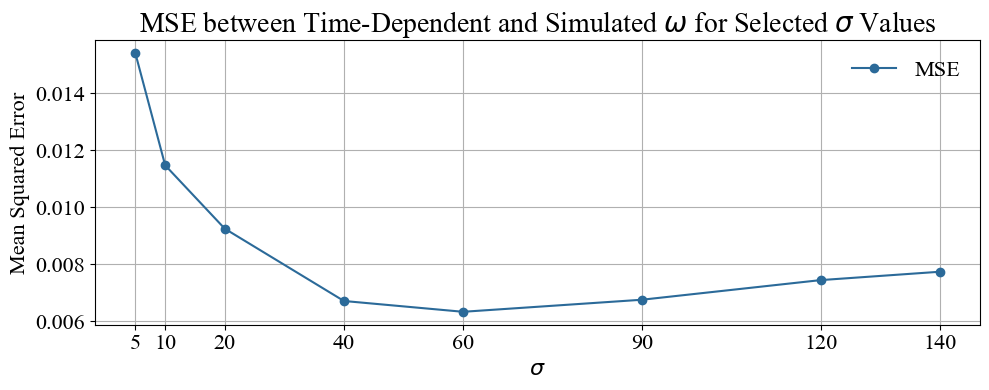

In [77]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_squared_error
plt.rcParams['font.family'] = 'Times New Roman'
# Specific sigma values to test
sigma_values = np.array([5, 10, 20, 40, 60, 90, 120, 140])
mse_values = []

for sigma in sigma_values:
    # Apply Gaussian filter with current sigma
    data_filtered = gaussian_filter1d(omega_Bal_time, sigma=sigma)
    
    # Integrate the filtered data to get theta (assuming integrate_data function is defined)
    theta = integrate_data(data_filtered, dt=1)
    
    # Run the SINDy model (assuming sindy_model function and necessary libraries are imported)
    model2 = sindy_model(data_filtered, threshold=1e-10, n=2)
    initial_condition = [theta[0], data_filtered[0], 0.00]
    simulated_data = model2.simulate(initial_condition, time_points)
    
    # Extract simulated omega
    simulated_omega = simulated_data[:, 1]
    
    # Calculate the MSE and store it
    mse = mean_squared_error(omega_Bal_time, simulated_omega)
    mse_values.append(mse)

# Plot the MSE against sigma values
plt.figure(figsize=(10, 4))
plt.plot(sigma_values, mse_values, label='MSE', marker='o', linestyle='-', color='#2b6a99')

plt.title('MSE between Time-Dependent and Simulated $\omega$ for Selected $\sigma$ Values', fontsize=20)
plt.xlabel('$\sigma$' , fontsize=16)
plt.ylabel('Mean Squared Error', fontsize=16)
plt.xticks(sigma_values,fontsize=16)  # Set x-ticks to be the sigma values
plt.yticks(fontsize=16)
plt.legend(fontsize=16,frameon=False)
plt.grid(True)
plt.tight_layout()

plt.savefig('C:/4. Paper plots/fig 3.pdf')
#plt.show()

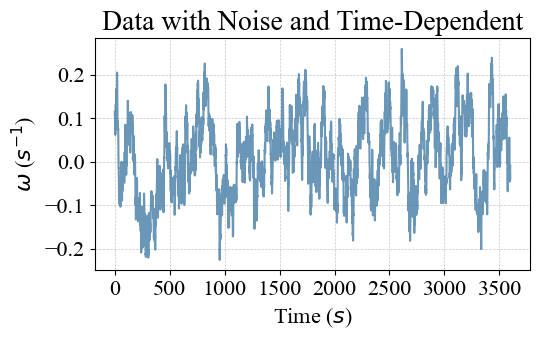

In [84]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(5.5, 3.5))

# Plot with specific colors for each line
plt.plot(omega_Bal_time, alpha=0.7, color='#2b6a99')
#plt.plot(data, label='Gaussian Filtered Omega', linestyle='-', linewidth=2,  color='#1b7c3d')
#plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3,  color='#f16c23')

plt.title('Data with Noise and Time-Dependent', fontsize=20)
plt.xlabel('Time ($s$)', fontsize=16)
plt.ylabel('$\omega$ ($s^{-1}$)', fontsize=16)

# Set x and y ticks font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(loc='upper right')  
#plt.locator_params(axis='x', nbins=10)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('C:/4. Paper plots/fig 1a.pdf')
#plt.show()

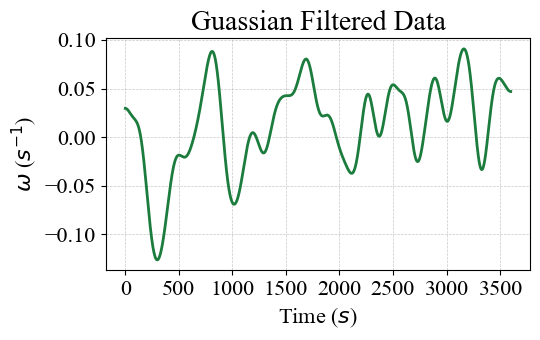

In [85]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(5.5, 3.5))

data=gaussian_filter1d(omega_Bal_time, sigma=60)
# Plot with specific colors for each line
#plt.plot(omega_Bal_time, alpha=0.7, color='#2b6a99')
plt.plot(data, linestyle='-', linewidth=2,  color='#1b7c3d')
#plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3,  color='#f16c23')

plt.title('Guassian Filtered Data', fontsize=20)
plt.xlabel('Time ($s$)', fontsize=16)
plt.ylabel('$\omega$ ($s^{-1}$)', fontsize=16)


# Set x and y ticks font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(loc='upper right')  
#plt.locator_params(axis='x', nbins=10)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('C:/4. Paper plots/fig 1b.pdf')
#plt.show()

(theta)' = -0.0003761 1 + -0.0000329 theta + 1.0013945 omega + 0.0000002 linear_time + -0.0000003 theta^2 + 0.0000575 theta omega + 0.0082394 omega^2 + -0.0000010 omega linear_time
(omega)' = -0.0002862 1 + -0.0000544 theta + 0.0085131 omega + -0.0000020 linear_time + -0.0000002 theta^2 + 0.0002465 theta omega + 0.0590083 omega^2 + -0.0000058 omega linear_time
(linear_time)' = 1.0000000 1
Model Score: 0.4948971619244647


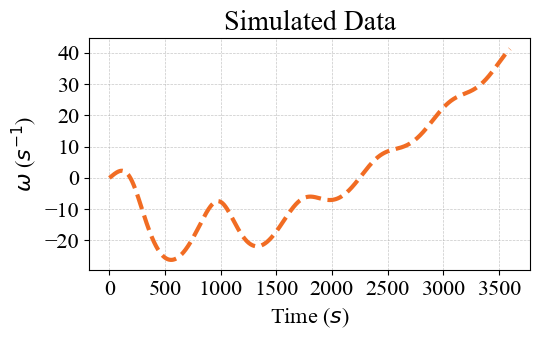

In [87]:
dt=1
data=gaussian_filter1d(omega_Bal_time, sigma=60)
theta = integrate_data(data, dt=1)
model2=sindy_model(data,threshold=1e-10,n=2)

# Simulate the system
total_time = len(theta)
time_points = np.arange(0, total_time, 1)

initial_condition = [theta[0], data[0], 0.00]
simulated_data = model2.simulate(initial_condition, time_points)

# Extract simulated theta and omega
simulated_theta = simulated_data[:, 0]
simulated_omega = simulated_data[:, 1]

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(5.5, 3.5))

data=gaussian_filter1d(omega_Bal_time, sigma=60)
# Plot with specific colors for each line
#plt.plot(omega_Bal_time, alpha=0.7, color='#2b6a99')
#plt.plot(data, linestyle='-', linewidth=2,  color='#1b7c3d')
plt.plot(simulated_omega,  linestyle='--', linewidth=3,  color='#f16c23')

plt.title('Simulated Data', fontsize=20)
plt.xlabel('Time ($s$)', fontsize=16)
plt.ylabel('$\omega$ ($s^{-1}$)', fontsize=16)



# Set x and y ticks font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(loc='upper right')  
#plt.locator_params(axis='x', nbins=10)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('C:/4. Paper plots/fig 1c.pdf')
#plt.show()

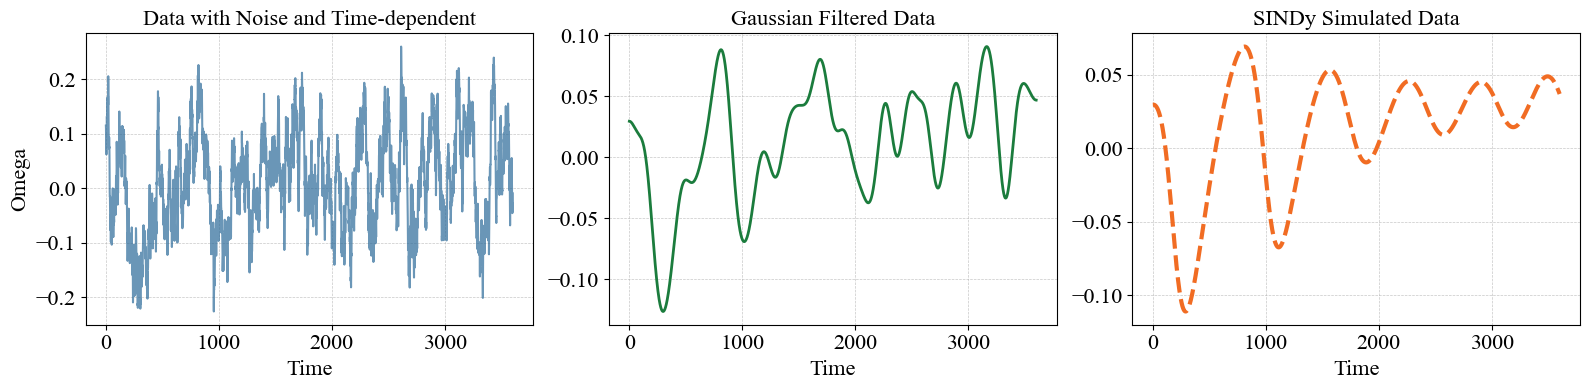

In [57]:
# Create subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(16, 4))  # Total figure size for 3 subplots (each 4x3)

# First subplot - Original Data with Noise and Time-dependency
axs[0].plot(omega_Bal_time, alpha=0.7, color='#2b6a99')
axs[0].set_title('Data with Noise and Time-dependent', fontsize=16)
axs[0].set_xlabel('Time', fontsize=16)
axs[0].set_ylabel('Omega', fontsize=16)
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Second subplot - Gaussian Filtered Data
axs[1].plot(data, linestyle='-', linewidth=2, color='#1b7c3d')
axs[1].set_title('Gaussian Filtered Data', fontsize=16)
axs[1].set_xlabel('Time', fontsize=16)
#axs[1].set_ylabel('Omega', fontsize=16)
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Third subplot - Simulated Data
axs[2].plot(simulated_omega, linestyle='--', linewidth=3, color='#f16c23')
axs[2].set_title('SINDy Simulated Data', fontsize=16)
axs[2].set_xlabel('Time', fontsize=16)
#axs[2].set_ylabel('Omega', fontsize=16)
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Set x and y ticks font size for all subplots
for ax in axs:
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()

#### Model 3

In [76]:
Bal_noise = noise_data_model_3['Balearic']
Ire_noise = noise_data_model_3['Irish']
Ice_noise = noise_data_model_3['Iceland']

Bal_ideal = ideal_data_model_3['Balearic']
Ire_ideal = ideal_data_model_3['Irish']
Ice_ideal = ideal_data_model_3['Iceland']

In [77]:
omega_Bal_noise, theta_Bal_noise = extract_data(Bal_noise,n=900)
omega_Ire_noise, theta_Ire_noise = extract_data(Ire_noise,n=900)
omega_Ice_noise, theta_Ice_noise = extract_data(Ice_noise,n=900)

omega_Bal_ideal, theta_Bal_ideal = extract_data(Bal_ideal,n=900)
omega_Ire_ideal, theta_Ire_ideal = extract_data(Ire_ideal,n=900)
omega_Ice_ideal, theta_Ice_ideal = extract_data(Ice_ideal,n=900)

In [78]:
q_3_model3, q_1_model3

({'Balearic': -0.13192368481446995,
  'Irish': -0.06322332030575732,
  'Iceland': -0.006585949084052546},
 {'Balearic': -0.021982100349774963,
  'Irish': -0.01093682972868459,
  'Iceland': -0.006288020191620842})

In [91]:
data=gaussian_filter1d(omega_Bal_noise, sigma=70)
theta = integrate_data(data, dt=1)
model3=sindy_model(data,threshold=1e-10, library_ensemble=True, n=3)

# Simulate the system
total_time = len(theta)
time_points = np.arange(0, total_time, 1)

initial_condition = [theta[0], data[0], 0.00]
simulated_data = model3.simulate(initial_condition, time_points)

# Extract simulated theta and omega
simulated_theta = simulated_data[:, 0]
simulated_omega = simulated_data[:, 1]

(theta)' = 0.0681483 1 + 0.0014620 theta + 1.7965699 omega + 0.0002098 linear_time + 0.0000658 theta^2 + -0.0060723 theta omega + 0.0000216 theta linear_time + 2.9088181 omega^2 + -0.0022619 omega linear_time + 0.0000016 linear_time^2 + -0.0000010 theta^3 + -0.0000734 theta^2 omega + -0.0000008 theta^2 linear_time + -0.0264016 theta omega^2 + -0.0000335 theta omega linear_time + -0.0000002 theta linear_time^2 + 3.1585132 omega^3 + -0.0079993 omega^2 linear_time + -0.0000037 omega linear_time^2
(omega)' = 0.1357664 1 + 0.0024598 theta + 1.5796029 omega + 0.0003162 linear_time + 0.0001058 theta^2 + -0.0146379 theta omega + 0.0000330 theta linear_time + 5.7419453 omega^2 + -0.0050819 omega linear_time + 0.0000022 linear_time^2 + -0.0000024 theta^3 + -0.0002102 theta^2 omega + -0.0000018 theta^2 linear_time + -0.0565805 theta omega^2 + -0.0000923 theta omega linear_time + -0.0000004 theta linear_time^2 + 6.2033281 omega^3 + -0.0168267 omega^2 linear_time + -0.0000099 omega linear_time^2
(l

In [92]:
# Apply Gaussian filter with sigma=20
data_sigma_20 = gaussian_filter1d(omega_Bal_noise, sigma=20)
# Integrate the filtered data to get theta
theta_sigma_20 = integrate_data(data_sigma_20, dt=1)

model3_sigma_20 = sindy_model(data_sigma_20, threshold=1e-10, library_ensemble=True, n=3)
# Simulate the system
simulated_data_sigma_20 = model3_sigma_20.simulate([theta_sigma_20[0], data_sigma_20[0], 0.00], time_points)
# Extract simulated omega
simulated_omega_sigma_20 = simulated_data_sigma_20[:, 1]

(theta)' = -0.0005234 1 + -0.0012990 theta + 0.9936082 omega + -0.0003433 linear_time + 0.0000192 theta^2 + -0.0079615 theta omega + 0.0000036 theta linear_time + 0.0225649 omega^2 + -0.0016523 omega linear_time + 0.0000001 linear_time^2 + -0.0000003 theta^3 + 0.0001822 theta^2 omega + -0.0000003 theta^2 linear_time + -0.0150795 theta omega^2 + 0.0000799 theta omega linear_time + -0.0000001 theta linear_time^2 + -0.0164580 omega^3 + -0.0030953 omega^2 linear_time + 0.0000088 omega linear_time^2
(omega)' = -0.0009669 1 + -0.0025609 theta + -0.0125111 omega + -0.0006800 linear_time + 0.0000376 theta^2 + -0.0152718 theta omega + 0.0000066 theta linear_time + 0.0575408 omega^2 + -0.0031515 omega linear_time + 0.0000001 linear_time^2 + -0.0000005 theta^3 + 0.0003750 theta^2 omega + -0.0000005 theta^2 linear_time + -0.0288284 theta omega^2 + 0.0001645 theta omega linear_time + -0.0000001 theta linear_time^2 + -0.0053007 omega^3 + -0.0059078 omega^2 linear_time + 0.0000180 omega linear_time^2

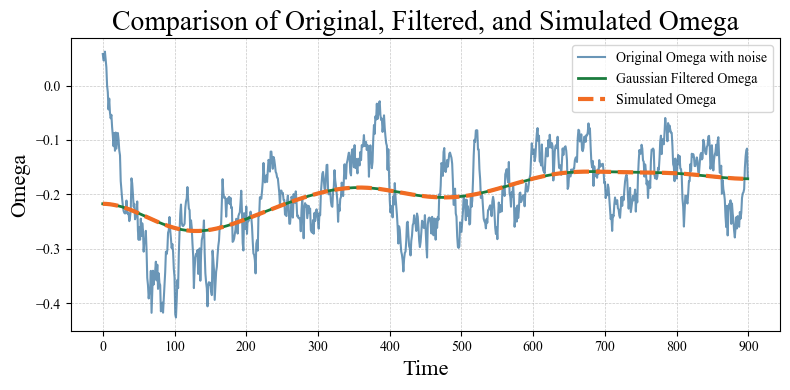

In [93]:
#plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(8, 4))

# Plot with specific colors for each line
plt.plot(omega_Bal_noise, label='Original Omega with noise', alpha=0.7, color='#2b6a99')
plt.plot(data, label='Gaussian Filtered Omega', linestyle='-', linewidth=2,  color='#1b7c3d')
plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3,  color='#f16c23')

# Plot Gaussian Filtered Omega with sigma=20 for comparison
#plt.plot(data_sigma_20, label='Gaussian Filtered Omega (sigma=20)', linestyle='-', linewidth=2, alpha=0.6,color='#1b7c3d')
# Plot Simulated Omega with sigma=20
#plt.plot(simulated_omega_sigma_20, label='Simulated Omega (sigma=20)', linestyle='--', linewidth=3, alpha=0.6,color='#f16c23')


plt.title('Comparison of Original, Filtered, and Simulated Omega', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Omega', fontsize=16)
plt.legend(loc='upper right')  
plt.locator_params(axis='x', nbins=10)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

#### Model 4

In [101]:
'''Model 4...'''
noise_data_model_4 = {i:[]for i in grids}
ideal_data_model_4 = {i:[]for i in grids}

c_1_model4 = {i:[]for i in grids}
c_2_model4 = {i:[]for i in grids}

'''adapt the parameter estimation to the particulat grids'''
for grid in grids:
    #raw=pd.read_csv('./Data/Frequency_data_%s.csv'%(grid), sep=',')
    #freq = (raw[['Frequency']]/1000 +50).squeeze()
    #freq = data_cleaning(freq)
    
    raw=pd.read_csv('Data/%s.csv'%(dict_grids[grid]), sep=';')  
    freq = (raw[[dict_freq_grids[grid]]]/1000 +50).squeeze()
    freq = data_cleaning(freq)
    
    data = (freq-50)*(2*np.pi)   #Use the angular velocity for the calcualltions

    trend = 1
    bw_drift, bw_diff = 0.05, 0.05
    if grid == 'Balearic':
        dist_theta, dist_omega = 20,20
        prim_control_lim, prim_weight = 0.13*2*np.pi, 3
        factor_daily_profile = 2.5 # set to 1 for small data set
    elif grid == 'Irish':
        dist_theta, dist_omega = 15,15
        prim_control_lim, prim_weight = 0.13*2*np.pi, 3
        factor_daily_profile = 3.2
        
    c_1 = KM_Coeff_1((data - trend*data_filter(data)),dim= 2,time_res = 1,bandwidth = bw_drift,dist = [dist_theta, dist_omega], order = 1)[0]
    c_2 = KM_Coeff_1((data - trend*data_filter(data)),dim= 2,time_res = 1,bandwidth = bw_drift,dist = [dist_theta, dist_omega], order = 1)[1]
    Delta_P = 0 
    epsilon =   KM_Coeff_2(data - trend*data_filter(data,sigma=300), dim = 2, time_res = 1, bandwidth = bw_diff, dist = [dist_theta, dist_omega], multiplicative_noise = True) #sigma = 60
    
    c_1_model4[grid] = c_1
    c_2_model4[grid] = c_2 
    
    delta_t = 1 #time step for Euler-Maruyama
    
    # with noise
    omega_noise_model_4, theta_noise_model_4 = Euler_Maruyama(data,c_1=c_1,c_2_decay=c_2,Delta_P = Delta_P,
                                                              epsilon=epsilon,time_res = 1,dispatch = 0,delta_t=delta_t,
                                                              t_final=900,model=4,factor_daily_profile=factor_daily_profile,
                                                              prim_control_lim = prim_control_lim, prim_weight = prim_weight)
    # without noise, set epsilon = 0
    omega_ideal_model_4, theta_ideal_model_4 = Euler_Maruyama(data,c_1=c_1,c_2_decay=c_2,Delta_P = Delta_P,
                                                              epsilon=[0,0],time_res = 1,dispatch = 0,delta_t=delta_t,
                                                              t_final=900,model=4,factor_daily_profile=factor_daily_profile,
                                                              prim_control_lim = prim_control_lim, prim_weight = prim_weight)
    
    noise_data_model_4[grid].append((omega_noise_model_4, theta_noise_model_4))
    ideal_data_model_4[grid].append((omega_ideal_model_4, theta_ideal_model_4))
    

    powers = np.array([[0,0],[1,0],[0,1],[1,1],[2,0],[0,2],[2,2]])
    bins = np.array([300,300])
    data_2d = np.array([integrate_omega(data - trend * data_filter(data),time_res=time_res,start_value = 0),data - trend * data_filter(data)]) #use theta as integrated omega
    kmc_2d[grid], edges_2d[grid] = km(data_2d.transpose(),powers = powers,bins = bins,bw=0.05)

Number of too high frequency values:  0 Number of too low frequency values:  0
Number of too large increments:  88
Number of windows with constant frequency for longer than 60s:  0
Number of Nan-intervals:  0
Clean corrupted data ...
Number of too high frequency values:  0 Number of too low frequency values:  0
Number of too large increments:  34
Number of windows with constant frequency for longer than 60s:  0
Number of Nan-intervals:  0
Clean corrupted data ...
Number of too high frequency values:  2 Number of too low frequency values:  0
Number of too large increments:  1126
Number of windows with constant frequency for longer than 60s:  0
Number of Nan-intervals:  0
Clean corrupted data ...


In [103]:
Bal_noise = noise_data_model_4['Balearic']
Ire_noise = noise_data_model_4['Irish']
Ice_noise = noise_data_model_4['Iceland']

Bal_ideal = ideal_data_model_4['Balearic']
Ire_ideal = ideal_data_model_4['Irish']
Ice_ideal = ideal_data_model_4['Iceland']


omega_Bal_noise, theta_Bal_noise = extract_data(Bal_noise,n=900)
omega_Ire_noise, theta_Ire_noise = extract_data(Ire_noise,n=900)
omega_Ice_noise, theta_Ice_noise = extract_data(Ice_noise,n=900)

omega_Bal_ideal, theta_Bal_ideal = extract_data(Bal_ideal,n=900)
omega_Ire_ideal, theta_Ire_ideal = extract_data(Ire_ideal,n=900)
omega_Ice_ideal, theta_Ice_ideal = extract_data(Ice_ideal,n=900)

In [104]:
c_1_model4

{'Balearic': -0.037720909847264755,
 'Irish': -0.02851536823553136,
 'Iceland': -0.002810858154136985}

In [105]:
c_2_model4

{'Balearic': -0.001020984365738198,
 'Irish': -0.0008868659265936632,
 'Iceland': -0.007722572663567426}

### Model 4 Balearic

In [119]:
data=gaussian_filter1d(omega_Bal_noise, sigma=90)
theta = integrate_data(data, dt=1)
model3=sindy_model(data,threshold=1e-10, library_ensemble=True, n=3)

# Simulate the system
total_time = len(theta)
time_points = np.arange(0, total_time, 1)

initial_condition = [theta[0], data[0], 0.00]
simulated_data = model3.simulate(initial_condition, time_points)

# Extract simulated theta and omega
simulated_theta = simulated_data[:, 0]
simulated_omega = simulated_data[:, 1]

(theta)' = -0.0256578 1 + 0.0014241 theta + 0.9886711 omega + 0.0007680 linear_time + 0.0000102 theta^2 + 0.0014018 theta omega + 0.0000042 theta linear_time + 0.0585748 omega^2 + 0.0005650 omega linear_time + -0.0000010 linear_time^2 + 0.0000024 theta^2 omega + 0.0002721 theta omega^2 + 0.0000004 theta omega linear_time + 0.0066070 omega^3 + -0.0000864 omega^2 linear_time + -0.0000002 omega linear_time^2
(omega)' = 0.0211651 1 + 0.0006604 theta + 0.0711382 omega + 0.0001761 linear_time + -0.0000068 theta^2 + 0.0013146 theta omega + -0.0000104 theta linear_time + 0.0953766 omega^2 + 0.0001147 omega linear_time + -0.0000034 linear_time^2 + 0.0000026 theta^2 omega + -0.0007344 theta omega^2 + 0.0000019 theta omega linear_time + 0.0604483 omega^3 + -0.0009545 omega^2 linear_time + 0.0000008 omega linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6666666406684201


In [120]:
# Apply Gaussian filter with sigma=20
data_sigma_20 = gaussian_filter1d(omega_Bal_noise, sigma=20)
# Integrate the filtered data to get theta
theta_sigma_20 = integrate_data(data_sigma_20, dt=1)

model3_sigma_20 = sindy_model(data_sigma_20, threshold=1e-10, library_ensemble=True, n=3)
# Simulate the system
simulated_data_sigma_20 = model3_sigma_20.simulate([theta_sigma_20[0], data_sigma_20[0], 0.00], time_points)
# Extract simulated omega
simulated_omega_sigma_20 = simulated_data_sigma_20[:, 1]

(theta)' = -0.0123603 1 + -0.0001883 theta + 0.9314908 omega + -0.0000087 theta^2 + 0.0025007 theta omega + -0.0000070 theta linear_time + -0.1464561 omega^2 + 0.0014848 omega linear_time + -0.0000019 linear_time^2 + -0.0000013 theta^2 omega + 0.0011433 theta omega^2 + -0.0000031 theta omega linear_time + -0.1113571 omega^3 + 0.0005439 omega^2 linear_time + -0.0000016 omega linear_time^2
(omega)' = -0.0674116 1 + -0.0110352 theta + -0.3245114 omega + -0.0059096 linear_time + -0.0000517 theta^2 + -0.0097696 theta omega + -0.0000130 theta linear_time + -0.4649290 omega^2 + -0.0046364 omega linear_time + 0.0000078 linear_time^2 + -0.0000001 theta^3 + -0.0000274 theta^2 omega + -0.0019085 theta omega^2 + -0.0000099 theta omega linear_time + -0.1765317 omega^3 + -0.0003325 omega^2 linear_time + 0.0000025 omega linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.637216122040478


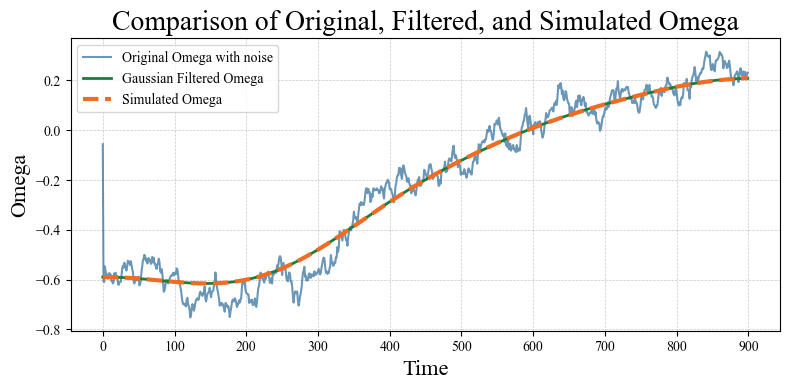

In [121]:
#plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(8, 4))

# Plot with specific colors for each line
plt.plot(omega_Bal_noise, label='Original Omega with noise', alpha=0.7, color='#2b6a99')
plt.plot(data, label='Gaussian Filtered Omega', linestyle='-', linewidth=2,  color='#1b7c3d')
plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3,  color='#f16c23')

# Plot Gaussian Filtered Omega with sigma=20 for comparison
#plt.plot(data_sigma_20, label='Gaussian Filtered Omega (sigma=20)', linestyle='-', linewidth=2, alpha=0.6,color='#1b7c3d')
# Plot Simulated Omega with sigma=20
#plt.plot(simulated_omega_sigma_20, label='Simulated Omega (sigma=20)', linestyle='--', linewidth=3, alpha=0.6,color='#f16c23')


plt.title('Comparison of Original, Filtered, and Simulated Omega', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Omega', fontsize=16)
plt.legend(loc='upper left')  
plt.locator_params(axis='x', nbins=10)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

(theta)' = -0.0270495 1 + -0.0005127 theta + 0.9321495 omega + -0.0002488 linear_time + -0.0000008 theta^2 + -0.0001068 theta omega + -0.0000003 theta linear_time + -0.0332291 omega^2 + 0.0000687 omega linear_time + 0.0000002 linear_time^2
(omega)' = -0.0488885 1 + -0.0010343 theta + -0.1233348 omega + -0.0005039 linear_time + -0.0000017 theta^2 + -0.0002018 theta omega + -0.0000006 theta linear_time + -0.0617887 omega^2 + 0.0001284 omega linear_time + 0.0000003 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.3899394196218055
(theta)' = -0.0232694 1 + -0.0004377 theta + 0.9401337 omega + -0.0002167 linear_time + -0.0000007 theta^2 + -0.0000733 theta omega + -0.0000003 theta linear_time + -0.0301588 omega^2 + 0.0000696 omega linear_time + 0.0000001 linear_time^2
(omega)' = -0.0444901 1 + -0.0008833 theta + -0.1148237 omega + -0.0004384 linear_time + -0.0000014 theta^2 + -0.0001432 theta omega + -0.0000006 theta linear_time + -0.0582792 omega^2 + 0.0001357 omega linear_time + 0

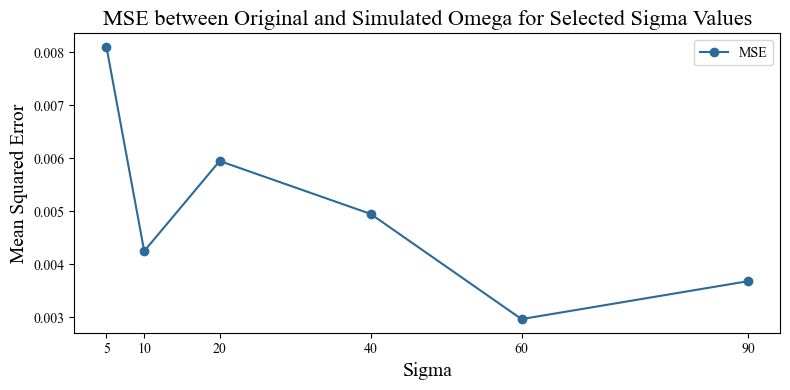

In [115]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_squared_error

# Specific sigma values to test
sigma_values = np.array([5, 10, 20, 40, 60, 90])
mse_values = []

for sigma in sigma_values:
    # Apply Gaussian filter with current sigma
    data_filtered = gaussian_filter1d(omega_Bal_noise, sigma=sigma)
    
    # Integrate the filtered data to get theta (assuming integrate_data function is defined)
    theta = integrate_data(data_filtered, dt=1)
    
    # Run the SINDy model (assuming sindy_model function and necessary libraries are imported)
    model2 = sindy_model(data_filtered, threshold=1e-10, n=2)
    initial_condition = [theta[0], data_filtered[0], 0.00]
    simulated_data = model2.simulate(initial_condition, time_points)
    
    # Extract simulated omega
    simulated_omega = simulated_data[:, 1]
    
    # Calculate the MSE and store it
    mse = mean_squared_error(omega_Bal_noise, simulated_omega)
    mse_values.append(mse)

# Plot the MSE against sigma values
plt.figure(figsize=(8, 4))
plt.plot(sigma_values, mse_values, label='MSE', marker='o', linestyle='-', color='#2b6a99')

plt.title('MSE between Original and Simulated Omega for Selected Sigma Values', fontsize=16)
plt.xlabel('Sigma', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.xticks(sigma_values)  # Set x-ticks to be the sigma values
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()



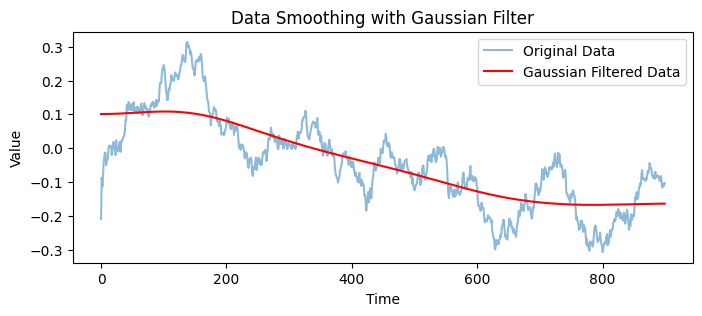

(theta)' = -0.0005665 1 + 0.0000320 theta + 0.9962336 omega + 0.0000092 linear_time + -0.0000005 theta^2 + -0.0025318 theta omega + -0.0000007 theta linear_time + 0.0919674 omega^2 + 0.0001369 omega linear_time + 0.0000201 theta^2 omega + 0.0018323 theta omega^2 + 0.0000040 theta omega linear_time + 0.0112304 omega^3 + -0.0000744 omega^2 linear_time + -0.0000002 omega linear_time^2
(omega)' = -0.0014300 1 + -0.0002067 theta + -0.0002261 omega + 0.0000406 linear_time + 0.0000044 theta^2 + -0.0050387 theta omega + -0.0000012 theta linear_time + 0.1288048 omega^2 + 0.0003130 omega linear_time + -0.0000001 theta^3 + 0.0000401 theta^2 omega + 0.0031082 theta omega^2 + 0.0000070 theta omega linear_time + 0.1393340 omega^3 + -0.0000056 omega^2 linear_time + -0.0000004 omega linear_time^2
(linear_time)' = 0.9999995 1 + -0.0000003 theta + -0.0000427 omega + 0.0000039 theta omega + 0.0005218 omega^2 + -0.0000004 omega linear_time + -0.0000006 theta omega^2 + -0.0004822 omega^3 + -0.0000014 omega

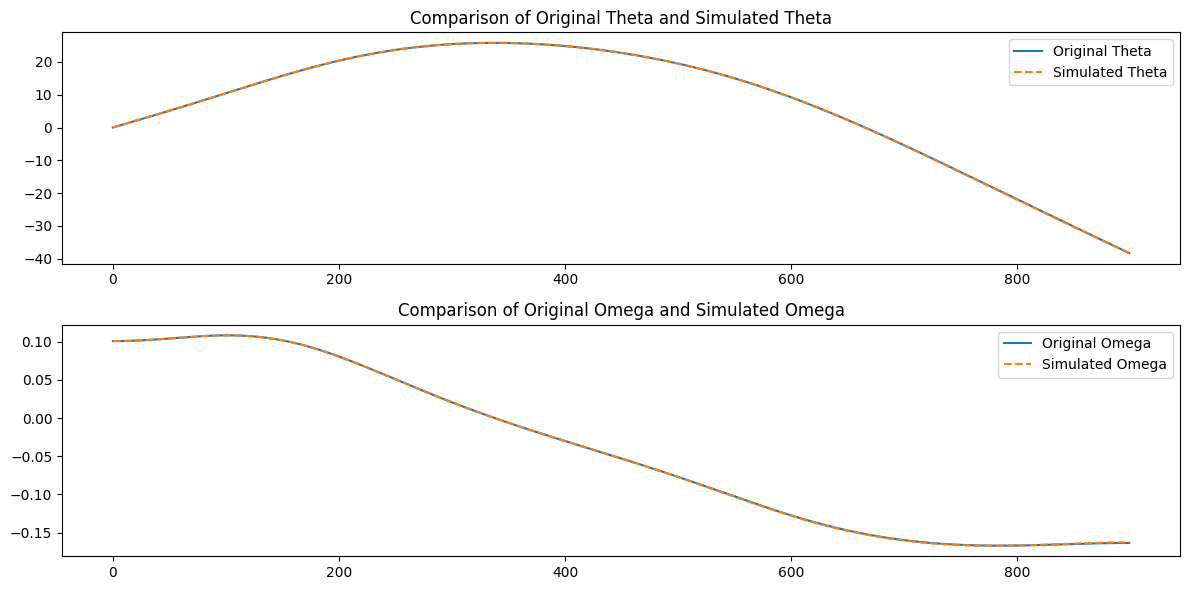

In [194]:
sindy_model(gaussian_filter(omega_Ire_noise, sigma=100),threshold=1e-20,n=3)

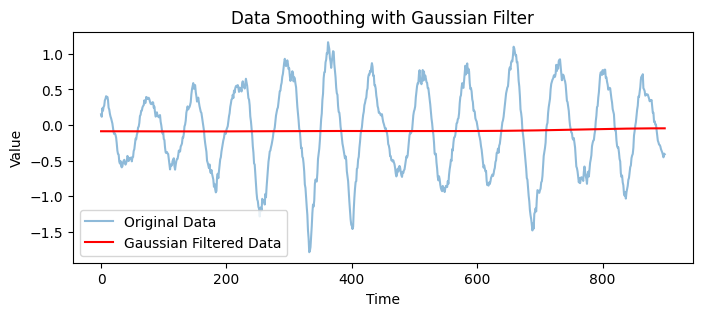

(theta)' = -0.0013156 1 + -0.0001297 theta + 0.9649603 omega + -0.0000115 linear_time + -0.0000170 theta^2 + 0.0009515 theta omega + -0.0000026 theta linear_time + -0.2295275 omega^2 + 0.0000807 omega linear_time + -0.0000001 linear_time^2
(omega)' = -0.0026003 1 + -0.0002584 theta + -0.0697471 omega + -0.0000230 linear_time + -0.0000344 theta^2 + 0.0019165 theta omega + -0.0000053 theta linear_time + -0.4593222 omega^2 + 0.0001619 omega linear_time + -0.0000002 linear_time^2
(linear_time)' = 1.0000000 1
Model Score: 0.6665608399779298


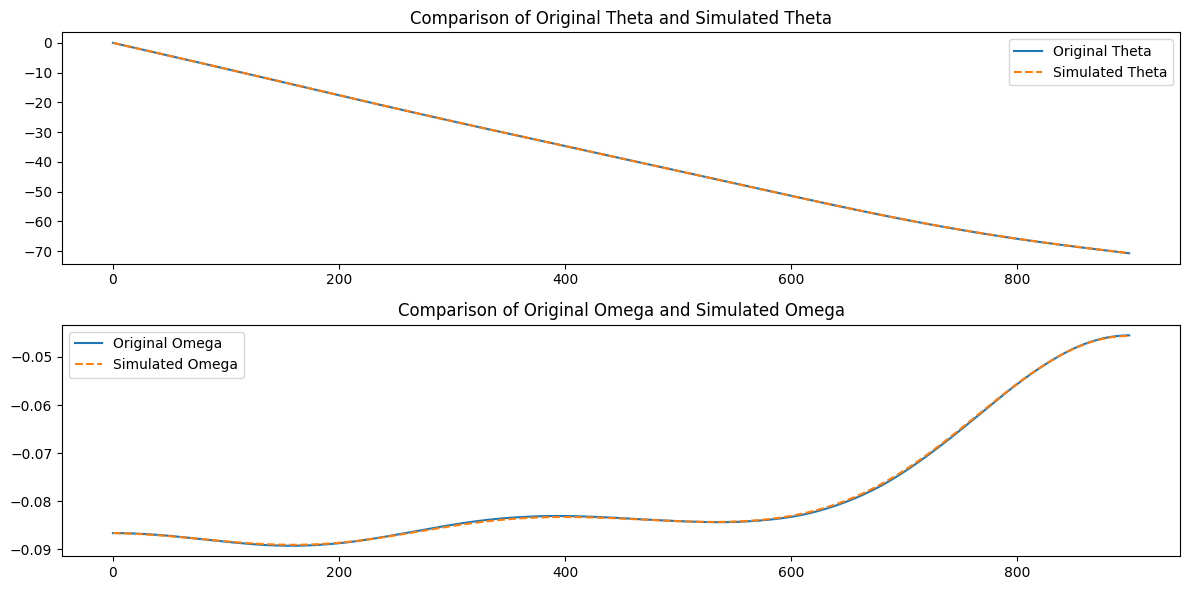

In [197]:
sindy_model(gaussian_filter(omega_Ice_noise, sigma=110),threshold=1e-20,n=2)

### Model 4 Ireland

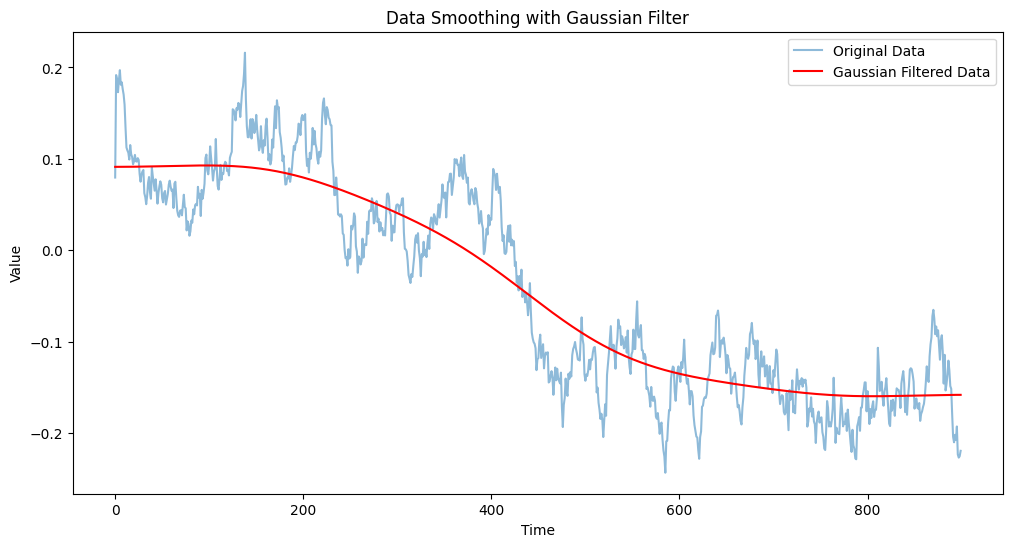

In [267]:
gaussian_filtered_data = gaussian_filter(omega_Ire, sigma=90)

data = gaussian_filtered_data
theta = integrate_data(data, dt)

In [268]:
x_train = np.column_stack((theta, data))
t_train = np.arange(0, len(data), 1)
# Add time as a linear feature
linear_time_feature = -t_train.reshape(-1, 1)
x_train_augmented = np.hstack([x_train, linear_time_feature])

# Feature names for SINDy (including a linear term for time)
feature_names = ["theta", "omega", "linear_time"]

# Use Polynomial Library with degree 1
polynomial_library = ps.PolynomialLibrary()

# Sparse regression optimizer
sparse_regression_optimizer = ps.STLSQ(threshold=1e-5)

# Create a SINDy model with the polynomial library
model = ps.SINDy(feature_names=feature_names, 
                 feature_library=polynomial_library,
                 optimizer=sparse_regression_optimizer)

# Fit the model (including the linear feature for time)
model.fit(x_train_augmented, t=dt, library_ensemble=True, quiet=True)
model.print(precision=5)
print("Model Score:", model.score(x_train_augmented, t=dt))

(theta)' = 0.00071 1 + -0.00003 theta + 0.98909 omega + 0.00003 theta omega + 0.03910 omega^2 + -0.00003 omega linear_time
(omega)' = -0.00055 1 + -0.00001 theta + 0.00291 omega + -0.00002 theta omega + 0.03675 omega^2
(linear_time)' = -1.00000 1
Model Score: 0.6586094389085445


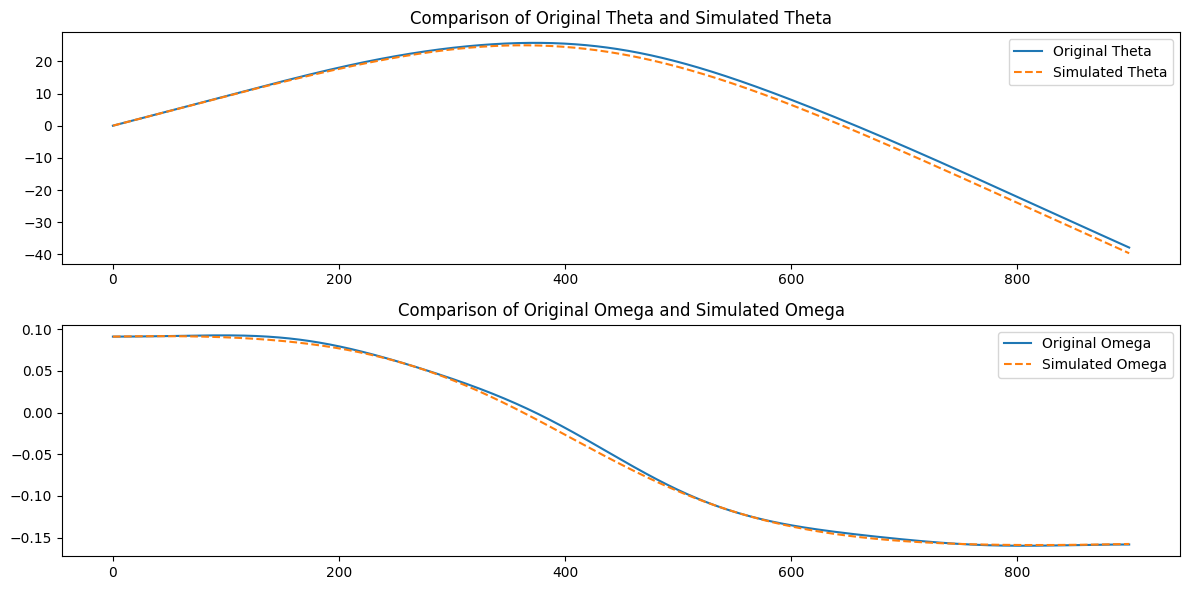

In [269]:
initial_condition = [theta[0], data[0],0]
compare_simulated_to_original(model, theta, data, initial_condition)

### Model 4 Iceland

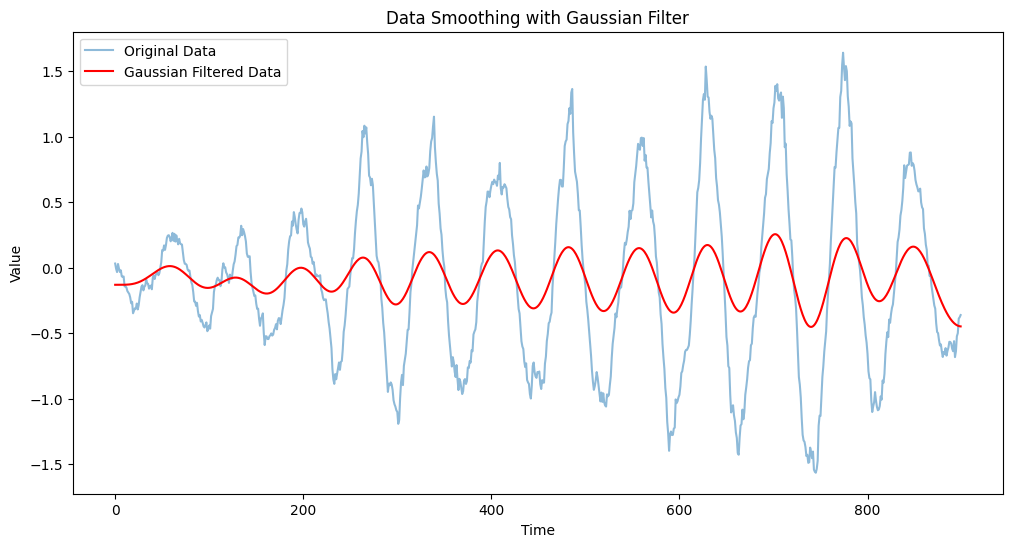

In [288]:
gaussian_filtered_data = gaussian_filter(omega_Ice, sigma=20)

data = gaussian_filtered_data
theta = integrate_data(data, dt)

In [297]:
x_train = np.column_stack((theta, data))
t_train = np.arange(0, len(data), 1)
# Add time as a linear feature
linear_time_feature = -t_train.reshape(-1, 1)
x_train_augmented = np.hstack([x_train, linear_time_feature])

# Feature names for SINDy (including a linear term for time)
feature_names = ["theta", "omega", "linear_time"]

# Use Polynomial Library with degree 1
polynomial_library = ps.PolynomialLibrary(degree=2)

# Sparse regression optimizer
sparse_regression_optimizer = ps.STLSQ(threshold=1e-5)

# Create a SINDy model with the polynomial library
model = ps.SINDy(feature_names=feature_names, 
                 feature_library=polynomial_library,
                 optimizer=sparse_regression_optimizer)

# Fit the model (including the linear feature for time)
model.fit(x_train_augmented, t=dt, library_ensemble=True, quiet=True)
model.print(precision=5)
print("Model Score:", model.score(x_train_augmented, t=dt))

(theta)' = -0.00330 1 + -0.00250 theta + 0.99850 omega + 0.00021 linear_time + 0.00001 theta omega + -0.01575 omega^2
(omega)' = -0.00605 1 + -0.00493 theta + 0.00330 omega + 0.00041 linear_time + 0.00086 theta omega + -0.03024 omega^2 + -0.00007 omega linear_time
(linear_time)' = -1.00000 1
Model Score: 0.5771349530007708


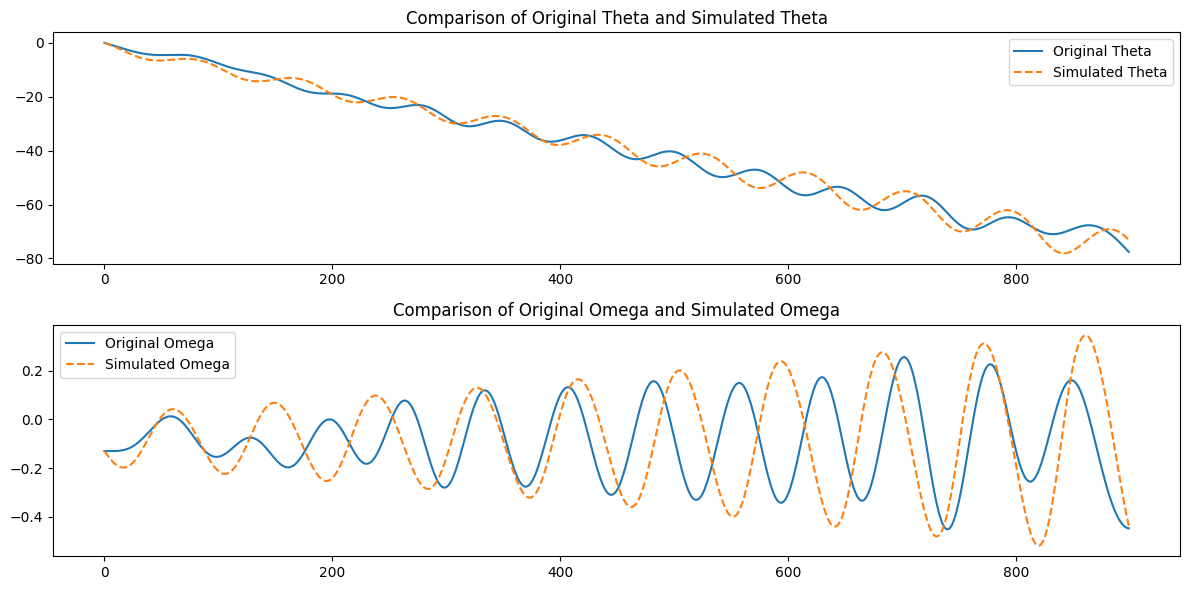

In [298]:
initial_condition = [theta[0], data[0],0]
compare_simulated_to_original(model, theta, data, initial_condition)